# Objective:

**To apply DBSCAN clustering algorithm on Amazon food reviews.**

DBSCAN does not require us to explicitely specify the number of clusters to be found, unlike KMeans. Since the dimensions of BoW and Tfidf are huge, DBSCAN will not be suitable for such data. I'll only apply it to W2V.

The important hyperparameters of DBSCAN are 
* epsilon : To be determined using the elbow curve

* min_samples : I'm fixing it at twice the number of dimensions 2*50 = 100 since the dimensionality of my w2v vectors is 50.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import sqlite3

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Load the data

In [3]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [4]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_avgW2V is : {}'.format(type(X_test_transformed_avgW2V)))
print('The shape of X_test_transformed_avgW2V is : {}'.format(X_test_transformed_avgW2V.shape))

The datatype of X_test_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_test_transformed_avgW2V is : (72835, 50)


In [5]:
X = np.vstack([X_train_transformed_avgW2V, X_test_transformed_avgW2V])

I tried to work with the entire dataset, but the machine would crash for > 30k points. Hence, I'm working with the maximum number of data points that my machine could handle.

In [7]:
X=X[:30000]

In [8]:
X.shape

(30000, 50)

**Standardize the data**

In [9]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Load the cleaned reviews from the original dataframe. These will be required for plotting wordclouds of clusters. 

In [10]:
con = sqlite3.connect('/home/ucanreachtvk/data/reviews_cleaned_final.sqlite')
# con = sqlite3.connect(r'C:\Users\ucanr\Downloads\reviews_cleaned_final.sqlite')
df_reviews_clean = pd.read_sql('select cleaned_text from Reviews;', con)

**Function: Elbow curve**

In [10]:
def plot_elbow_curve(X, k=100):
    """
    This will plot the distances of k'th nearest neighbor
    of each point along the y axis, sorted in ascending order
    It will help us choose the right epsilon using the elbow point
    """

    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors = k, n_jobs=10)
    neigh.fit(X)

    distances = []
    
    for i in range(X.shape[0]):
        
        dist, _ = neigh.kneighbors(X[i].reshape(1,-1))        
        # distance of the k'th nearest neighbor of i'th point
        distances.append(dist.tolist()[0][-1])
        
    plt.style.use('bmh')
    plt.figure(figsize=(15,6))
    plt.plot(sorted(distances), marker='.',linestyle='none',scaley=True)
    plt.xticks([])
    plt.title('Elbow Curve for choosing epsilon')
    plt.ylabel('Distance')
    plt.xlabel('For each X[i], distance of the {}th nearest neighbor in increasing order'.format(k))

**Function: Plot wordcloud to represent clusters**

In [11]:
def plot_wordcloud(prediction_array, df_reviews_clean, n, clusters=[0]):
    """
        Display K wordclouds for a certain value of K(#clusters) created using
        n sample reviews belonging to each cluster 
    """
    samples = []

    for cluster_no in clusters:

        ix = np.where(prediction_array == cluster_no)
        
        samples.append(df_reviews_clean.iloc[ix]['cleaned_text'].head(n))
    
    
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    
    for cluster_no in clusters:
        
        big_review = ' '
        
        for review in list(samples[cluster_no]):
            
            big_review = big_review + review.decode('utf-8')
                    
        plt.subplot(len(clusters), 1,cluster_no+1)
        wc = WordCloud(width=900, height=900).generate(big_review)
        _ = plt.imshow(wc, interpolation='bilinear')
        _ = plt.title('Cluster {}'.format(cluster_no))
        _ = plt.axis("off")

    
    _ = plt.show()
    _ = plt.tight_layout()
    
    return samples

## Plot the elbow curve to choose the appropriate value of epsilon

As you can see in the graph below, distance of the hundredth nearest neighbor for some points increases suddenly about the value 10. Let's take this as epsilon.

CPU times: user 15min 15s, sys: 1min 48s, total: 17min 3s
Wall time: 1h 26min 22s


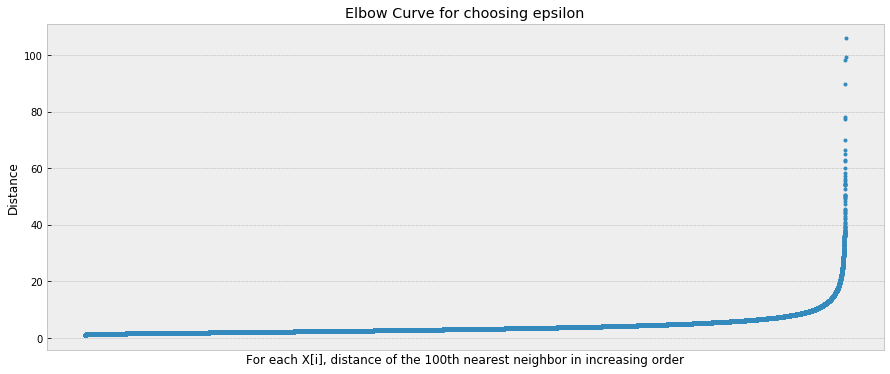

<IPython.core.display.Javascript object>

In [11]:
%%notify
%%time

plot_elbow_curve(X_std)

** DBSCAN | epsilon = 10**

In [13]:
%%notify
%%time


dbscan = DBSCAN(eps=10, min_samples=100, n_jobs = 1)
predictions = dbscan.fit_predict(X_std)

CPU times: user 2min 56s, sys: 9.94 s, total: 3min 6s
Wall time: 3min 6s


<IPython.core.display.Javascript object>

Let's check the number of unique clusters predicted by DBSCAN.

Note that the value -1 represents noisy points and there's only one cluster - 0. 

In [14]:
np.unique(predictions)

array([-1,  0])

Let's create a wordcloud from 1000 sample reviews belonging to the cluster 0.

The words like flavor, taffi (stemed form of some word), chewi (probably stemed form of chewing), peanut are found the most. 

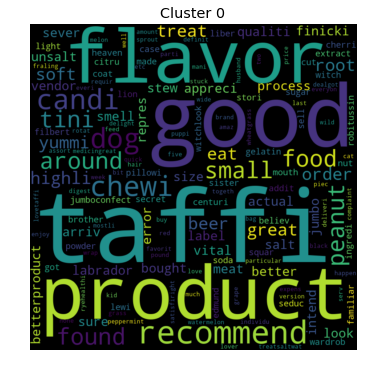

<Figure size 432x288 with 0 Axes>

In [15]:
_ = plot_wordcloud(predictions, df_reviews_clean, n=1000, clusters=[0])

**DBSCAN | epsilon = 20**

Let's double the value of epsilon and see what happens

In [16]:
%%notify
%%time


dbscan = DBSCAN(eps=20, min_samples=100, n_jobs = 1)
predictions = dbscan.fit_predict(X_std)

CPU times: user 1min 19s, sys: 6.51 s, total: 1min 26s
Wall time: 1min 26s


<IPython.core.display.Javascript object>

Again, only one clusteris generated. Cluster - 0

In [17]:
np.unique(predictions)

array([-1,  0])

Again create a wordcloud from the reviews belonging to this cluster.

Words such as good, food, flavor, oatmeal, sugar are found frequently.

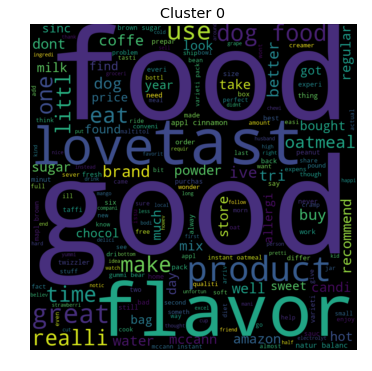

<Figure size 432x288 with 0 Axes>

In [18]:
_ = plot_wordcloud(predictions, df_reviews_clean, n=100, clusters=[0])

**DBSCAN | epsilon = 0.5**

In [19]:
%%notify
%%time


dbscan = DBSCAN(eps=0.5, min_samples=100, n_jobs = 1)
predictions = dbscan.fit_predict(X_std)

CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 18 s


<IPython.core.display.Javascript object>

Let's check the number of clusters generated.

Surprisingly, every point is classified as noise when we make epsilon = 0.5

In [20]:
np.unique(predictions)

array([-1])

**DBSCAN | epsilon = 5**

In [24]:
%%notify
%%time


dbscan = DBSCAN(eps=5, min_samples=100, n_jobs = 1)
predictions = dbscan.fit_predict(X_std)

CPU times: user 2min 50s, sys: 2.01 s, total: 2min 52s
Wall time: 2min 52s


<IPython.core.display.Javascript object>

Check the number of clusters generated.

Just one cluster again, with rest classified as noise.

In [25]:
np.unique(predictions)

array([-1,  0])

Create wordcloud from the reviews belonging to this cluster.

Words such as flavor, taste, chip, buy, sweet, coffee are found frequently. 

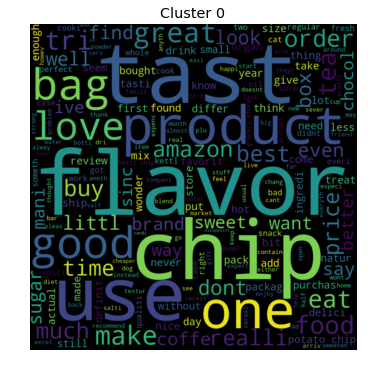

<Figure size 432x288 with 0 Axes>

In [26]:
_ = plot_wordcloud(predictions, df_reviews_clean, n=1000, clusters=[0])

**DBSCAN | epsilon = 50**

In [21]:
%%notify
%%time


dbscan = DBSCAN(eps=50, min_samples=100, n_jobs = 1)
predictions = dbscan.fit_predict(X_std)

CPU times: user 18.8 s, sys: 5.22 s, total: 24 s
Wall time: 24 s


<IPython.core.display.Javascript object>

Once again, just one cluster is generated.

In [22]:
np.unique(predictions)

array([-1,  0])

Creating a word cloud from the reviews in that cluster.

The words that stand out are - flavor, chip, taste, good, love etc.

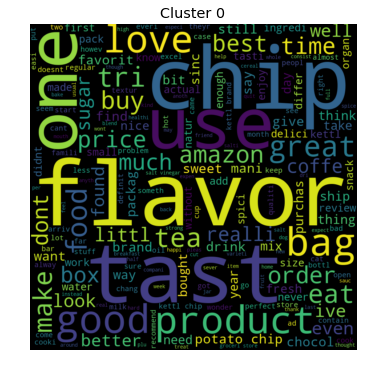

<Figure size 432x288 with 0 Axes>

In [23]:
_ = plot_wordcloud(predictions, df_reviews_clean, n=1000, clusters=[0])

**DBSCAN | epsilon = 100**

In [27]:
%%notify
%%time


dbscan = DBSCAN(eps=100, min_samples=100, n_jobs = 1)
predictions = dbscan.fit_predict(X_std)

CPU times: user 10.6 s, sys: 5.87 s, total: 16.4 s
Wall time: 16.4 s


<IPython.core.display.Javascript object>

This time, all the points have been added into the cluster and there are no noise points.

In [28]:
np.unique(predictions)

array([0])

Generate a wordcloud

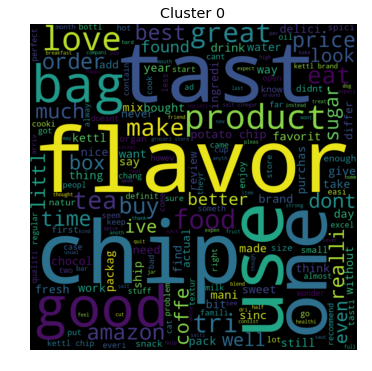

<Figure size 432x288 with 0 Axes>

In [29]:
_ = plot_wordcloud(predictions, df_reviews_clean, n=1000, clusters=[0])

## Conclusion:

* Applied DBSCAN on Amazon Food Reviwes.
* Plotted the elbow curve to choose the value of epsilon.
* Tested several values of epsilon and tested how the value affects the clusters.